## imports

In [57]:
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
import json
data_pth = Path('../data/')

## Constants

In [58]:
NIU = 99999999
with open(data_pth / 'cpi99_cons.json') as fin:
    cpi99_cons = json.load(fin)

Drop useless columns

In [59]:
raw_data = pd.read_csv('../data/beginner.csv')
simple_data = raw_data[[
    'YEAR', 'SERIAL', 'REGION', 'NFAMS', 'PERNUM', 
    'AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 
    'WKSTAT', 'JOBCERT', 'EDUC', 'INCWAGE', 'OINCWAGE']]
simple_data.to_csv('../data/simple_data.csv', index=False)

In [60]:
incwage = simple_data['INCWAGE']
print('total reports:', len(incwage))
print('number of 0 wage:', np.count_nonzero(incwage == 0))
print('number of N.I.U wage:', np.count_nonzero(incwage == 99999999))
print('number of ? wage:', np.count_nonzero(incwage == 99999998))
print('number of NaN wage:', np.count_nonzero(incwage.isna()))
print('number of readable wage:', np.count_nonzero((incwage > 0) & (incwage < 99999998)))


total reports: 54737
number of 0 wage: 7496
number of N.I.U wage: 5543
number of ? wage: 0
number of NaN wage: 30160
number of readable wage: 11538


In [61]:
filtered = simple_data[(simple_data['INCWAGE'] >= 0) & (simple_data['INCWAGE'] < NIU)].reset_index(drop=True)

filtered_nonzero = filtered[filtered['INCWAGE'] > 0].reset_index(drop=True)


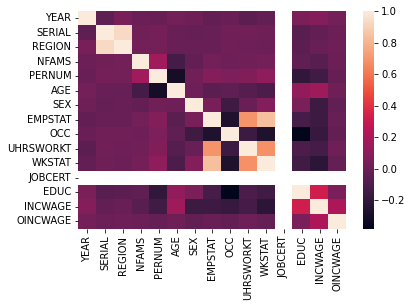

In [62]:
import seaborn as sns
corr = filtered_nonzero.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


In [63]:
# per individual

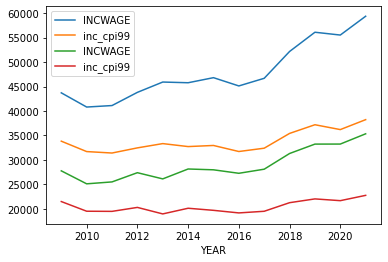

In [66]:
def clean_wage(df):
    # df['OINCWAGE'] = df['OINCWAGE'].replace(np.nan, 0).replace(99999999, 0).replace(99999998, 0)
    # df['inc_salary'] = df['INCWAGE'] - df['OINCWAGE']

    df['cpi99'] = df['YEAR'].apply(lambda yr : cpi99_cons[str(yr)])
    df['inc_cpi99'] = df['INCWAGE'] * df['cpi99']

    df.groupby('YEAR').mean()['INCWAGE'].plot(legend=True)
    df.groupby('YEAR').mean()['inc_cpi99'].plot(legend=True)

clean_wage(filtered_nonzero)
# plt.figure()
clean_wage(filtered)


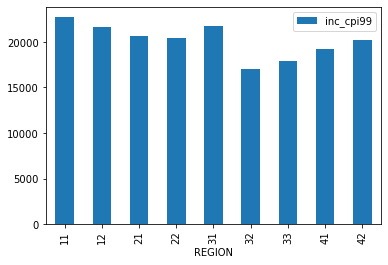

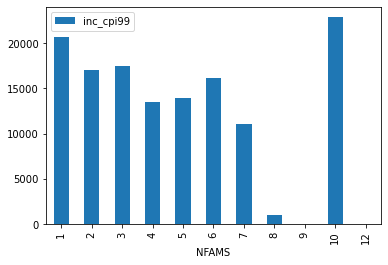

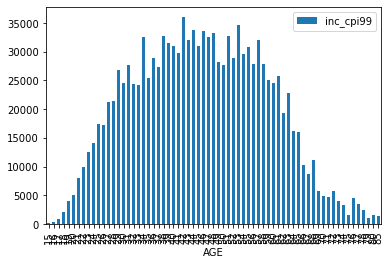

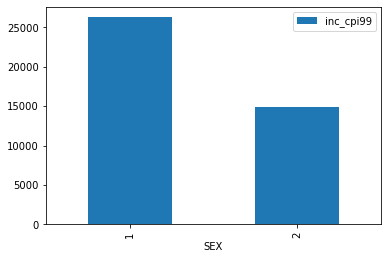

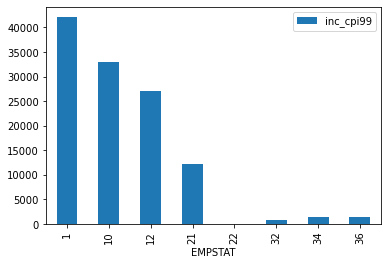

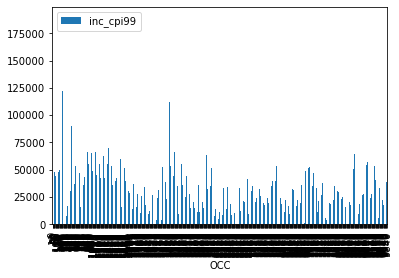

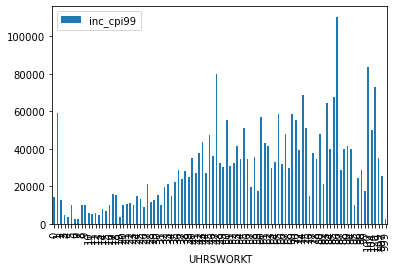

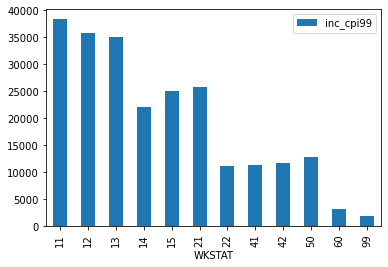

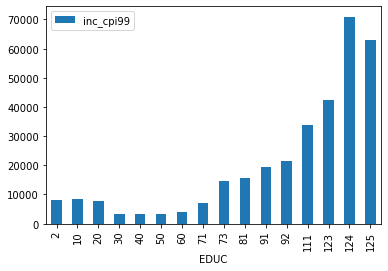

<Figure size 432x288 with 0 Axes>

In [68]:
def display_categ(df, it):
    # salary = df['inc_salary_cpi99']
    # it = df[it]
    df.groupby(it).mean()['inc_cpi99'].plot(kind="bar", legend=True)
    plt.figure()

indices = ['REGION', 'NFAMS', 'AGE', 'SEX', 'EMPSTAT', 'OCC', 'UHRSWORKT', 'WKSTAT', 'EDUC']

for idx in indices:
    display_categ(filtered, idx)